In [1]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
## Loading in the extracted, normalized, binned spectral lighcurves
## from my 'Extracting the Transmission Spectra time series' notebook
#tsdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/normalizedSpectralTimeSeries.npz')
tsdata = np.load('./Transit_Spectra_NoFirst_Visit3.npz')
times = tsdata['time']
rawfluxes = tsdata['flux']
rawerrors = tsdata['error']
scandirs = tsdata['scandir']
#waves = tsdata['wavelengths']

fluxes = np.copy(rawfluxes)
errors = np.copy(rawerrors)
Nbins = rawfluxes.shape[0]
for wav in range(Nbins):
    # normalizing thomas'
    sd1_idxs = np.where(scandirs == 1.)[0]
    sd0_idxs = np.where(scandirs == 0.)[0]
    
    # if normalizing by max flux in second orbit:
#     orbit2_sd1 = rawfluxes[wav,:][sd1_idxs][:8]
#     orbit2_sd0 = rawfluxes[wav,:][sd0_idxs][:8]
#     normval1, normval0 = np.max(orbit2_sd1), np.max(orbit2_sd0)
    # if normalizing by median flux of whole visit
    normval1 = np.median(fluxes[wav, sd1_idxs])
    normval0 = np.median(fluxes[wav, sd0_idxs])
    
    fluxes[wav, sd1_idxs] /= normval1
    errors[wav, sd1_idxs] /= normval1
    fluxes[wav, sd0_idxs] /= normval0
    errors[wav, sd0_idxs] /= normval0

Npoints = fluxes.shape[1]
Nwaves = fluxes.shape[0]

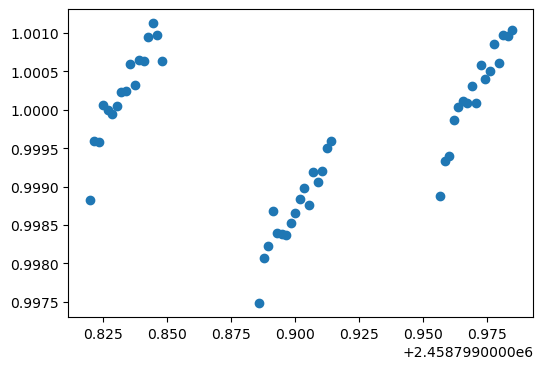

In [3]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(times, fluxes[0,:])
plt.show()

In [4]:
##
# Defining my parameter arrays (inits, priors, etc)
# I'll fix all of the orbital parameters to values gotten from my broadband fitting
# Here, I'll only fit the transit depths and systematic parameters
# I should also look into using single systematics based on broadband fitting too
rprs_init, rprs_init_unc = 0.0439177, 0.00027693

t0_fixed = 2458329.201974941
P_fixed = 6.03447168385
a_fixed = 13.4136
inc_fixed = 86.4225
ecc_fixed = 0.
w_fixed = 90.
u_fixed = [0.05, 0.35]#[0.33, 0.2]

amplitude_init, amperr_init = 0.0012, 0.01 #0.00189344, 3.18044e-5
# amplitude_o3_init, amperr_o3_init = 0.00150679, 3.27505e-5
# amplitude_o4_init, amperr_o4_init = 0.00167709, 2.94116e-5
    
tau_init, tauerr_init = -0.005,0.01 #0.00560405, 0.00012699
# tau_o3_init, tauerr_o3_init = 0.00494686, 0.00024072
# tau_o4_init, tauerr_o4_init = 0.00532261, 0.00024142

slope_init, slopeerr_init = -0.0065, 0.01 #-0.00235749, 0.00018181
intcpt_init, intcpterr_init =  1.0000+0.0011, 0.01 #1.0, 2.e-5

# Initializing the BATMAN model
InitParams = batman.TransitParams()
InitParams.t0 = t0_fixed     
InitParams.per = P_fixed
InitParams.a = a_fixed
InitParams.inc = inc_fixed
InitParams.rp = rprs_init
InitParams.ecc = ecc_fixed
InitParams.w = w_fixed
InitParams.limb_dark = 'quadratic'
InitParams.u = u_fixed
BATMAN_initmodel = batman.TransitModel(InitParams, times)

In [13]:
##
# Defining my astrophysical models

def transit(rprs, initmodel):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = pre-initialized BATMAN model environment, which increases efficiency
    
    # Unpack input parameters
    tc = t0_fixed       # time of conjunction [days]
    P = P_fixed  # compute Period in [day]
    a = a_fixed  # compute a/Rstar
    inc = inc_fixed  # Compute inclination in [deg]
    ecc = ecc_fixed    # use these if assuming circular orbit
    omega = w_fixed
    rprstar = rprs
        
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    params.ecc = ecc
    params.w = omega
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = u_fixed
    
    lightcurve = initmodel.light_curve(params)
    return lightcurve

##
# Defining my systematic models
def hook(theta):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]
    
    amplitude = theta[1]
    tau = theta[2]
    
    # Pull out times [in day; MJD] of each orbit
    orbit_ends = np.array([17, 34, 51])
    orbit2times = times[:orbit_ends[0]]
    orbit3times = times[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times[orbit_ends[1] : orbit_ends[2]]
    
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    
    orbit2hook = 1. - amplitude*np.exp(tinorbit2 / tau)
    orbit3hook = 1. - amplitude*np.exp(tinorbit3 / tau)
    orbit4hook = 1. - amplitude*np.exp(tinorbit4 / tau)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve

def ramp(theta):
    # Visit-long linear model for flux in time
    # Inputs:
    # theta
    # time
    slope = theta[3]
    intercept = theta[4]
    
    t_adj = times - times[0]#np.median(times)
    y = (slope * t_adj) + intercept
    return y

In [40]:
def logLikelihood(ydata, yerr, modely):
    
    #likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    #lnL = np.sum(likelihoodarray)
    lnLikarray = ((ydata - modely)**2. / (yerr**2.)) + np.log(2. * np.pi * yerr**2.)
    lnL = -0.5*np.sum(lnLikarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    if not (0. <= theta[0] <= 1.):
        return -np.inf
    #if (theta[1] > 0.1):
    #    return -np.inf
    # compute priors
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            # If not applying a prior on a parameter, it's listed as inf in the array
            #continue
            lnP += 0.
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

def lnPosterior(theta):
    
    prior_array = mc_priors
    priorerrs_array = mc_priorserr
    flux_array = mc_flux
    unc_array = mc_errs
        
    tran = transit(theta[0], BATMAN_initmodel)
    hoo = hook(theta)
    ram = ramp(theta)
    model = tran * hoo * ram
        
    lnlikelihood = logLikelihood(mc_flux, mc_errs, model)
    
#     # Compute and check priors
    lnPrior_value = logPriors(theta, prior_array, priorerrs_array)
    if not np.isfinite(lnPrior_value):
        return -np.inf

    # Compute posterior
    lnPost = lnlikelihood
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

In [41]:
res = {
    'spec0':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec1':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec2':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec3':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec4':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec5':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec6':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec7':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec8':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec9':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec10':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec11':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec12':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec13':{
        'fits': np.array([]),
        'errs': np.array([])
    },
    'spec14':{
        'fits': np.array([]),
        'errs': np.array([])
    }
}

In [42]:
Nburn = 3000
Nsteps = 5000


for wav in range(Nwaves):
    print('on bin ', wav)
    mc_flux, mc_errs = fluxes[wav,:], errors[wav,:]
    
    theta_init = np.array([rprs_init, amplitude_init, tau_init, slope_init, intcpt_init])
    priors = np.array([np.inf, amplitude_init, tau_init, slope_init, intcpt_init])
    priorerrs = np.array([rprs_init_unc, amperr_init, tauerr_init, slopeerr_init, intcpterr_init])
    mc_priors, mc_priorserr = np.copy(priors), np.copy(priorerrs)
    lnPost_init = lnPosterior(theta_init)
    print(lnPost_init)
    
    # Setting up and initializing MCMC
    Ndimensions = len(theta_init)
    Nwalkers = 3*Ndimensions

    # Initializing walker positions
    pos = np.zeros((Nwalkers, Ndimensions))
    for i in range(Ndimensions):
        pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorerrs[i], Nwalkers)
    print('running burn-in')
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
        sampler.run_mcmc(pos, Nburn, progress=True);
        
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)
    burn = int(Nburn-100)
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]

    burn_vals = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    burn_err = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - burn_vals
    
    pos = np.zeros((Nwalkers, Ndimensions))
    for i in range(Ndimensions):
        pos[:,i] = burn_vals[i] + 0.5*np.random.normal(0., burn_err[i], Nwalkers)
    print('running mcmc')
    with Pool() as pool: 
        sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, pool=pool)
        sampler.run_mcmc(pos, Nsteps, progress=True);\
        
    samples = sampler.get_chain()
    flatsamples = sampler.get_chain(flat=True)

    burn = 0
    samples = samples[burn:]
    flatsamples = flatsamples[burn*Nwalkers:]

    param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
    param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])
    gausserrs = np.mean((param_uperrs, param_loerrs), axis=0)
    
    
    res['spec'+str(wav)]['fits'] = param_fits
    res['spec'+str(wav)]['errs'] = gausserrs

on bin  0
312.54187782596057
running burn-in


100%|██████████| 3000/3000 [00:04<00:00, 658.97it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 653.18it/s]

on bin  1
310.09882443604516
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 657.58it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 659.41it/s]

on bin  2
311.9225359732816
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 653.57it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 658.08it/s]

on bin  3
320.4315034438048
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 652.16it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 648.44it/s]

on bin  4
323.56054570917354
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 643.68it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 657.16it/s]

on bin  5
320.743216372529
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 657.36it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 651.85it/s]

on bin  6
327.1925031914747
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 650.04it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 652.50it/s]

on bin  7
330.0019301858407
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 652.55it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 648.63it/s]

on bin  8
325.880268767207
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 660.90it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 651.01it/s]

on bin  9
325.9930872097986
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 651.61it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 657.85it/s]

on bin  10
320.5900532681474
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 654.46it/s]


running mcmc


100%|██████████| 5000/5000 [00:07<00:00, 651.00it/s]

on bin  11
326.41002474133427
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 649.51it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 650.15it/s]

on bin  12
324.44901785228325
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 651.20it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 655.26it/s]

on bin  13
324.49954685643604
running burn-in



100%|██████████| 3000/3000 [00:04<00:00, 647.38it/s]

running mcmc



100%|██████████| 5000/5000 [00:07<00:00, 656.00it/s]


on bin  14
321.7902979527807
running burn-in


100%|██████████| 3000/3000 [00:04<00:00, 654.30it/s]


running mcmc


100%|██████████| 5000/5000 [00:07<00:00, 643.10it/s]


In [43]:
res

{'spec0': {'fits': array([ 4.04344234e-02,  1.01253949e-01, -2.01395959e+00, -1.48063964e-04,
          1.11210960e+00]),
  'errs': array([0.00225576, 0.04892839, 1.22339267, 0.00167085, 0.06225517])},
 'spec1': {'fits': array([ 4.04905841e-02,  1.10955480e-01, -1.94715877e+00, -2.70321734e-04,
          1.12424484e+00]),
  'errs': array([0.00219332, 0.04060135, 0.81563132, 0.001597  , 0.05139893])},
 'spec2': {'fits': array([ 4.14453417e-02,  1.36383504e-01, -2.69023025e+00,  6.46165549e-04,
          1.15743962e+00]),
  'errs': array([0.00204269, 0.05640749, 1.36022192, 0.00191175, 0.07161885])},
 'spec3': {'fits': array([ 4.04371976e-02,  7.78513156e-02, -2.01903405e+00, -1.78864066e-03,
          1.08428050e+00]),
  'errs': array([0.00209456, 0.04919669, 1.36857933, 0.00146838, 0.05966253])},
 'spec4': {'fits': array([ 0.04038514,  0.07015287, -1.8433908 , -0.00187966,  1.07515416]),
  'errs': array([0.0019888 , 0.03492069, 1.19245663, 0.00143379, 0.04077486])},
 'spec5': {'fits': 

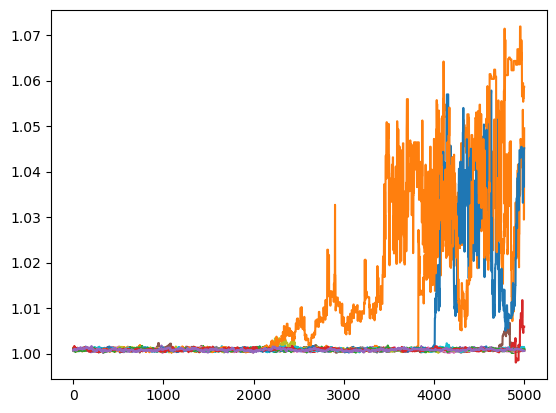

In [44]:
x = np.arange(samples.shape[0])
plt.plot(x, samples[:,:,4])
plt.show()

In [45]:
samples.shape

(5000, 15, 5)

In [46]:
depths = np.zeros(Nwaves)
deptherrs = np.copy(depths)
for wav in range(Nwaves):
    rprs = res['spec'+str(wav)]['fits'][0]
    err = res['spec'+str(wav)]['errs'][0]
    
    depth = rprs**2
    derr = depth*(err/rprs)*np.sqrt(2)
    depths[wav] = depth
    deptherrs[wav] = derr

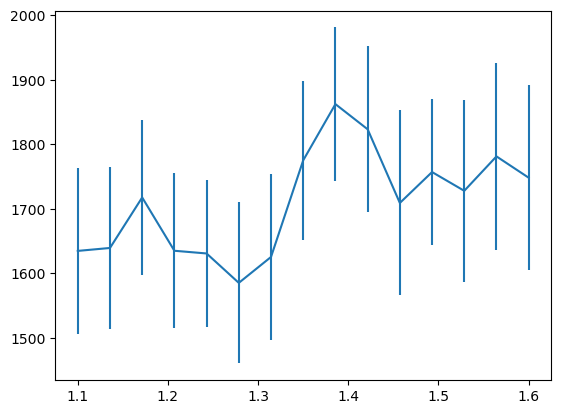

In [47]:
waves = np.linspace(1.1, 1.6, len(depths))
plt.errorbar(waves, depths*1.e6, yerr=deptherrs*1.e6)
plt.show()

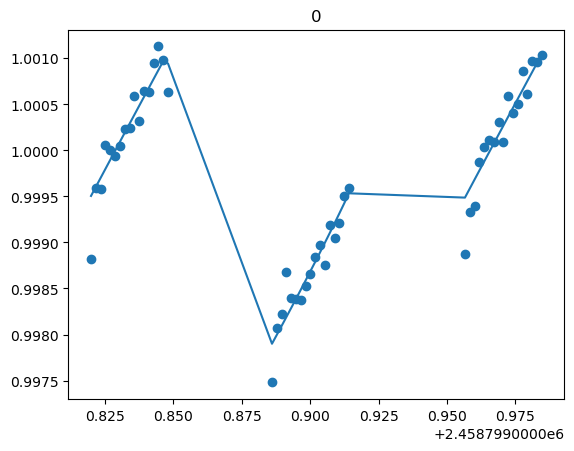

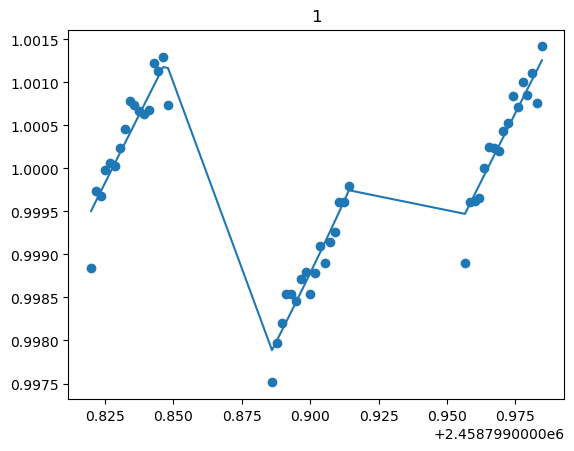

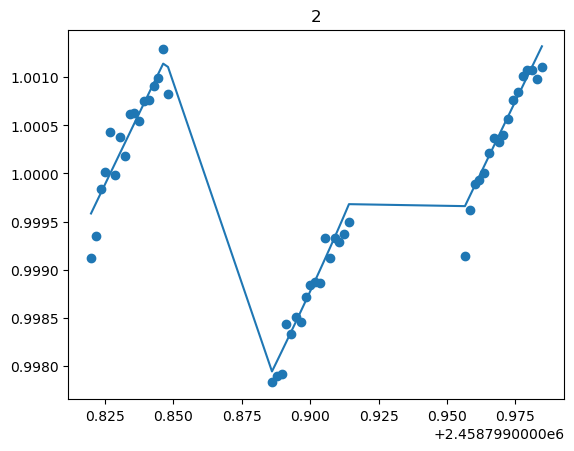

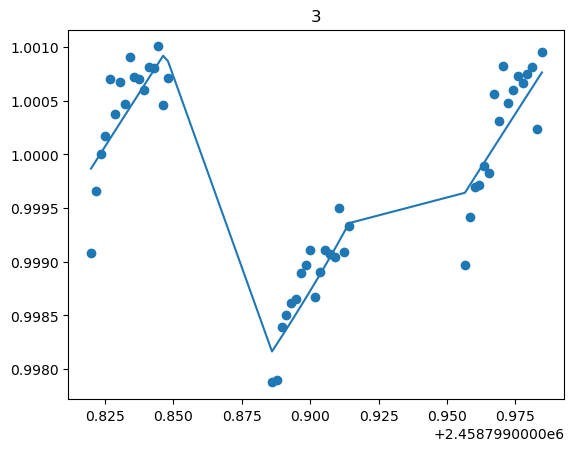

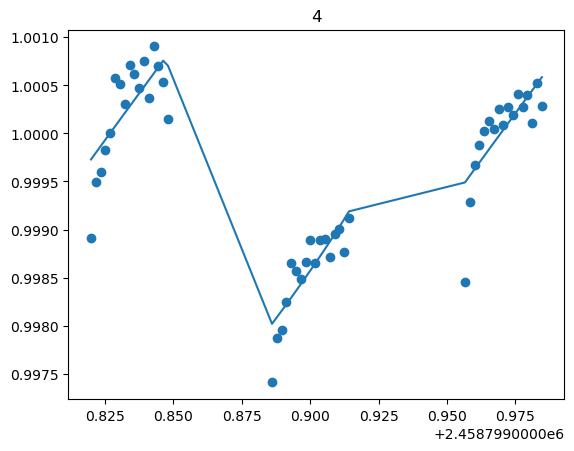

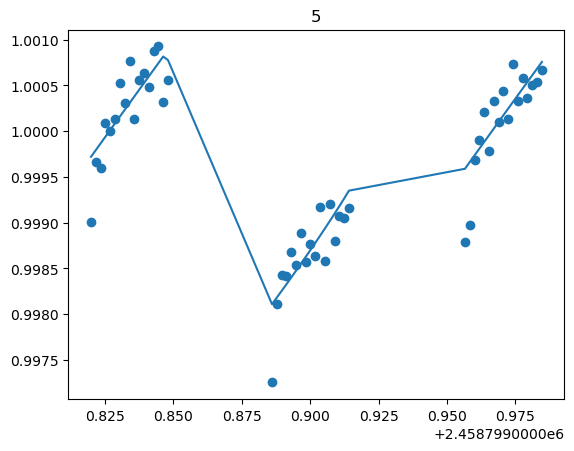

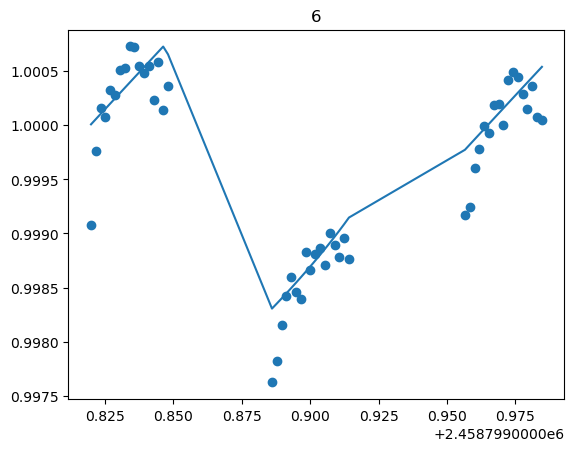

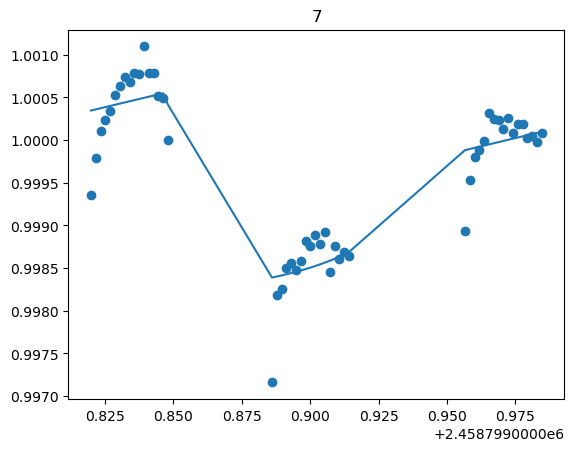

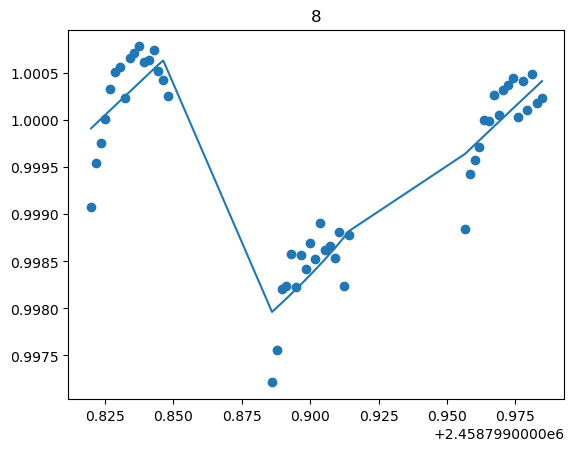

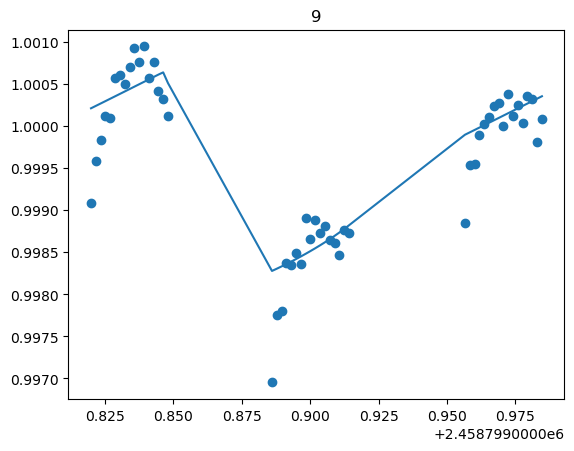

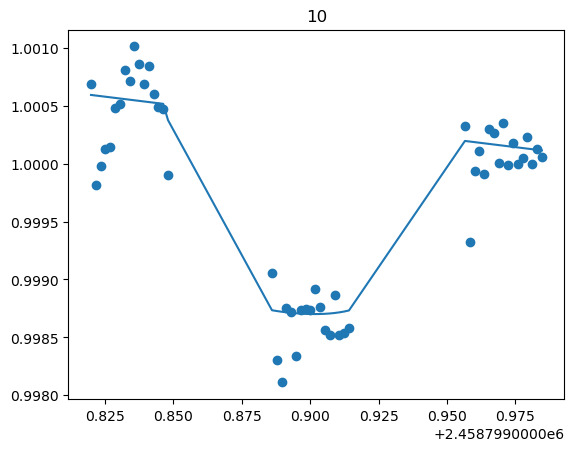

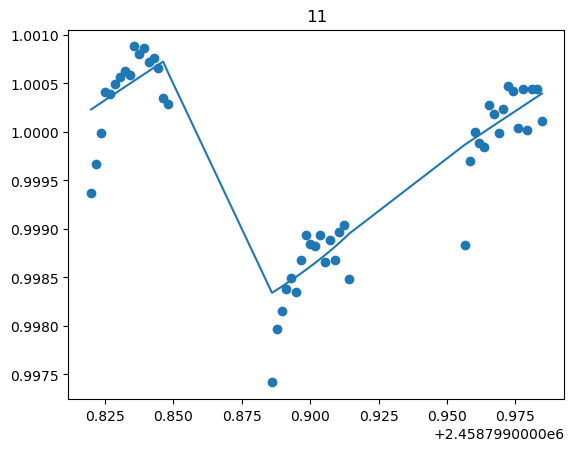

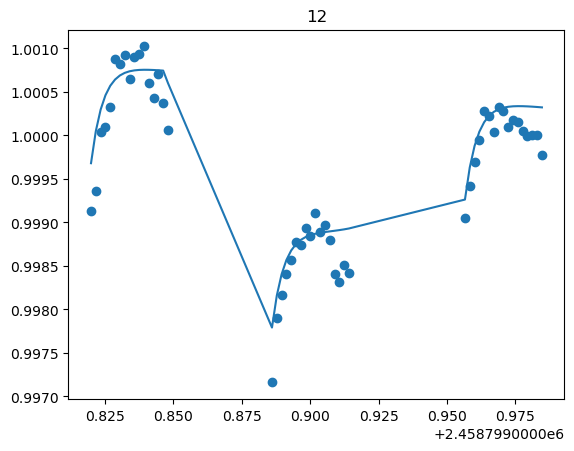

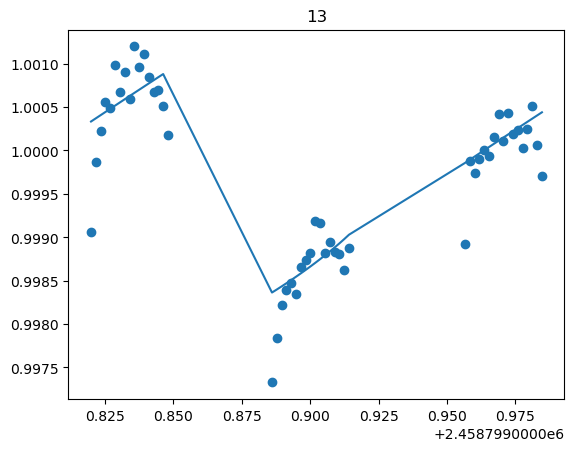

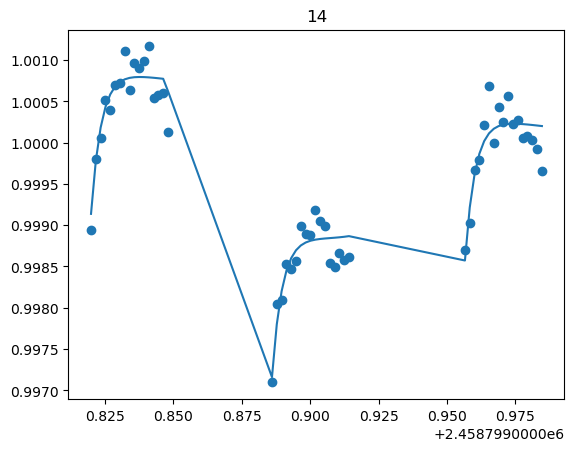

In [48]:
for wav in range(Nwaves):
    params = res['spec'+str(wav)]['fits']
    
    tran = transit(params[0], BATMAN_initmodel)
    hoo = hook(params)
    ram = ramp(params)
    model = tran * hoo * ram
    
    plt.title(wav)
    plt.plot(times, model)
    plt.scatter(times, fluxes[wav,:])
    plt.show()

In [50]:
mp_sh_depths = np.copy(depths)
mp_sh_deptherrs = np.copy(deptherrs)
%store mp_sh_depths
%store mp_sh_deptherrs

Stored 'mp_sh_depths' (ndarray)
Stored 'mp_sh_deptherrs' (ndarray)


In [51]:
%store -r tp_depths
%store -r tp_deptherrs

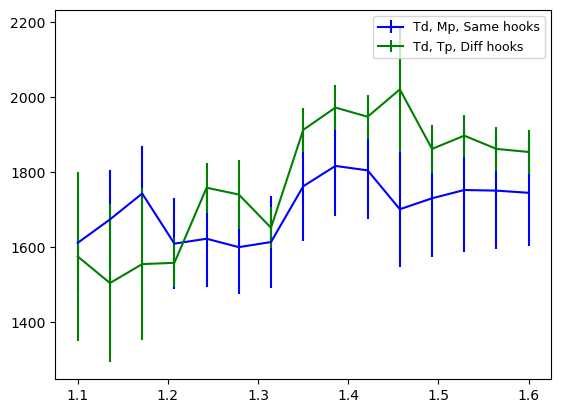

In [52]:
plt.errorbar(waves, depths*1.e6, yerr=deptherrs*1.e6, c='blue', label='Td, Mp, Same hooks')
plt.errorbar(waves, tp_depths*1.e6, yerr=tp_deptherrs*1.e6, c='green', label='Td, Tp, Diff hooks')
plt.legend(loc='best', fontsize=9)
plt.show()